# Tarea de Clustering

## Introducción
Esta tarea consiste en la implementación en python del algoritmo de k-means desde cero, tomando en cuenta las siguientes características:
<ol>
    <li>
        <strong>Comparación de implementaciones de k-means:</strong> Se ha realizado una comparación de los resultados obtenidos con el algoritmo implementado desde cero y el algoritmo que ofrece la librería <a href="https://scikit-learn.org/stable/">sickit-learn</a>.
    </li>
    <li>
        <strong>Comparación de algoritmos:</strong> Se ha realizado una comparación de resultados entre los algoritmos k-medoids y k-means.
    </li>
    <li>
        <strong>Uso de clustering jerárquico:</strong> ...
    </li>
    <li>
        <strong>Evaluación del rendimiento:</strong> Se ha utilizado la silueta para evaluar el rendimiento de todos los métodos.
    </li>    
</ol>

<strong>Estudiante:</strong> Mónica Gabriela Cabañas Meléndez 

### Importación de librerías necesarias y carga de datos

In [11]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

In [12]:
# Loading the data
data = pd.read_csv('wine-clustering.csv')

# Displaying the first 5 rows of the data
data.head(5)

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


### Visualización de datos

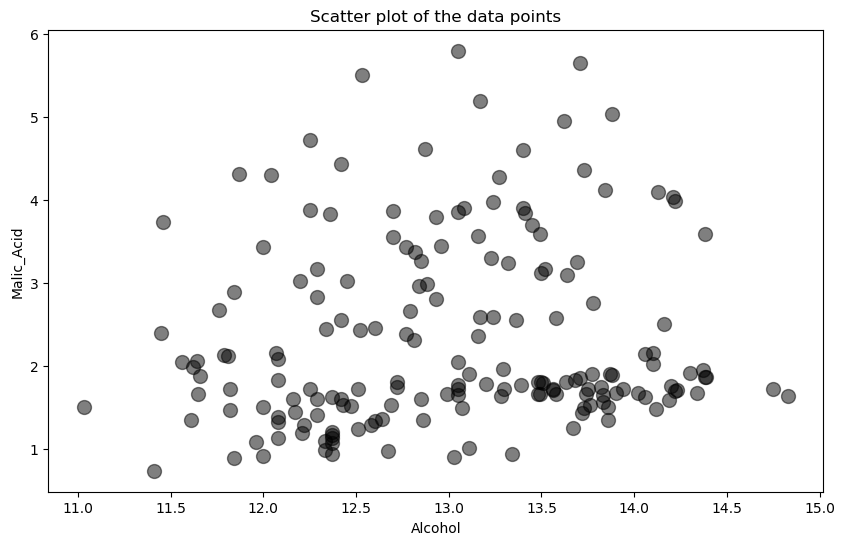

In [15]:
# Function to plot the data points of two features
def plot_data(feature1, feature2):
    plt.figure(figsize=(10, 6))
    plt.scatter(data[feature1], data[feature2], s=100, c='black', alpha=0.5)
    plt.title('Scatter plot of the data points')
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.show()

# Ploting the data points of two features
plot_data(data.columns[0], data.columns[1])

# Normalización

### Inicialización de centroides

Uno de los primeros pasos para ejecutar el algoritmo de K-Means es inicializar los centroides que no son más que puntos con $ d $ dimensiones que serán ubicados en el espacio de manera aleatoria. Para ello procederemos a crear una matriz de dimensión $K \times d$ que contendrá los $ K $ centroides:

In [18]:
K = 3
centroids = np.random.randn(K, data.shape[1])
print('Dimensión de la matriz: ' , centroids.shape)

Dimensión de la matriz:  (3, 13)


### Estandarización de centroides

* 

### Función para obtener la distancia euclidiana

Para encontrar la distancia entre dos puntos $(x_{1}^{(1)}, x_{2}^{(1)})$,  $(x_{1}^{(2)}, x_{2}^{(2)})$ en donde solo hay dos dimensiones: $x_{1}$ y $x_{2}$, esta se calcula de la siguiente manera: 

$$ 
    \sqrt{(x_{1}^{(1)} - x_{1}^{(2)})^2 + (x_{2}^{(1)} - x_{2}^{(2)})^2} 
$$

Si se le agregan más dimensiones a ambos puntos por igual la distancia euclídea podrá ser calculada de la siguiente manera:
$$
    \sqrt{\sum_{i = 1}^d{(punto1 - punto2)^2}}
$$

Dado de que en la vida real se utilizan $ d $ dimensiones para entrenar un modelo, el código para calcular la distancia euclídea se ha realizado tomando en cuenta las siguientes características 
* La función recibe dos vectores con dimensiones $1 \times d$
* Cada vector representa un punto con $ d $ dimensiones

In [ ]:
# Function for obtaining the result of the euclidean distance between two matrices
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))